# Examples Using blackmarblepy Package

__Table of Contents__
* [Setup](#setup)
* [Make raster of nighttime lights](#make_rasters)
* [Make raster stack of nighttime lights across multiple time periods](#make_stacks)
* [Map of nighttime lights](#map)
* [Compute trends on nighttime lights over time](#trends)
* [Exporting raster data to files](#to_file)

## Setup <a name="setup">

#### Install blackmarblepy

In [1]:
! pip uninstall blackmarblepy --yes

Found existing installation: blackmarblepy 0.1.0
Uninstalling blackmarblepy-0.1.0:
  Successfully uninstalled blackmarblepy-0.1.0


In [ ]:
! pip install git+https://github.com/ramarty/blackmarblepy.git

  Cloning https://github.com/ramarty/blackmarblepy.git to /private/var/folders/m1/8h14xfm56hd6qfgz6btm1rd80000gn/T/pip-req-build-hkvow4d1
  Running command git clone -q https://github.com/ramarty/blackmarblepy.git /private/var/folders/m1/8h14xfm56hd6qfgz6btm1rd80000gn/T/pip-req-build-hkvow4d1
  Resolved https://github.com/ramarty/blackmarblepy.git to commit a18381b437b926fd27eaff28b92adefc738eacd9
  Created wheel for blackmarblepy: filename=blackmarblepy-0.1.0-py3-none-any.whl size=14019 sha256=0b906c8cedad74bb42b27f5fef50e33387929abf3df1205823f3960cc050691a
  Stored in directory: /private/var/folders/m1/8h14xfm56hd6qfgz6btm1rd80000gn/T/pip-ephem-wheel-cache-lebtc_a3/wheels/2d/74/2a/3f0e00273b80606a21c3dcb8689e2ca07c529a0802ea86bbd3
Successfully built blackmarblepy


#### Load Packages

In [3]:
import geopandas as gpd
from gadm import GADMDownloader

import rasterio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
import datetime
import glob
import time

from blackmarblepy.bm_raster import bm_raster
from blackmarblepy.bm_extract import bm_extract

#### Define NASA Bearer

For instructions on obtaining a NASA bearer token, see [here](https://github.com/ramarty/blackmarbler#bearer-token-).

In [4]:
if os.path.exists("/Users/robmarty/Desktop/bearer_bm.csv"):
    bearer = pd.read_csv("/Users/robmarty/Desktop/bearer_bm.csv")['token'][0]
else:
    bearer == "BEARER TOKEN HERE"

#### Define Region of Interest

Define region of interest for where we want to download nighttime lights data

In [5]:
downloader = GADMDownloader(version="4.0")

country_name = "Ghana"
ad_level = 1
roi_sf = downloader.get_shape_data_by_country_name(country_name=country_name, ad_level=ad_level)

## Make raster of nighttime lights <a name="make_rasters">

The below example shows making daily, monthly, and annual rasters of nighttime lights for Ghana.

In [6]:
### Daily data: raster for February 5, 2021
r_20210205 = bm_raster(roi_sf = roi_sf,
                       product_id = "VNP46A2",
                       date = "2021-02-05",
                       bearer = bearer)

Downloading: VNP46A2.A2021036.h17v07.001.2021105023833.h5
Downloading: VNP46A2.A2021036.h17v08.001.2021104054945.h5
Downloading: VNP46A2.A2021036.h18v07.001.2021105032141.h5
Downloading: VNP46A2.A2021036.h18v08.001.2021104041403.h5


In [7]:
### Monthly data: raster for October 2021
r_202110 = bm_raster(roi_sf = roi_sf,
                     product_id = "VNP46A3",
                     date = "2021-10",
                     bearer = bearer)

Downloading: VNP46A3.A2021274.h17v07.001.2021321132719.h5
Downloading: VNP46A3.A2021274.h17v08.001.2021321132826.h5
Downloading: VNP46A3.A2021274.h18v07.001.2021321132715.h5
Downloading: VNP46A3.A2021274.h18v08.001.2021321132727.h5


In [8]:
### Annual data: raster for 2021
r_2021 = bm_raster(roi_sf = roi_sf,
                    product_id = "VNP46A4",
                    date = 2021,
                    bearer = bearer)

Downloading: VNP46A4.A2021001.h17v07.001.2022094115525.h5
Downloading: VNP46A4.A2021001.h17v08.001.2022094115514.h5
Downloading: VNP46A4.A2021001.h18v07.001.2022094115526.h5
Downloading: VNP46A4.A2021001.h18v08.001.2022094115509.h5


## Make raster stack of nighttime lights across multiple time periods <a name="make_stacks">

To extract data for multiple time periods, add multiple time periods to date. The function will return a raster stack, where each raster band corresponds to a different date. The below code provides examples getting data across multiple days, months, and years.

By setting `quiet = True`, we can hide output that shows downloading progress and other messages.

In [9]:
#### Raster stack of daily data
date_list = pd.date_range(datetime.datetime.strptime("2021-03-01", "%Y-%m-%d"), 
                          datetime.datetime.strptime("2021-03-03", "%Y-%m-%d"), 
                          freq='D').strftime("%Y-%m-%d").tolist()

r_daily = bm_raster(roi_sf = roi_sf,
                     product_id = "VNP46A2",
                     date = date_list,
                     bearer = bearer,
                     quiet = True)

In [9]:
#### Raster stack of monthly data
date_list = pd.date_range(datetime.datetime.strptime("2021-01-01", "%Y-%m-%d"), 
                                            datetime.datetime.strptime("2021-03-31", "%Y-%m-%d"), 
                                            freq='M').strftime("%Y-%m-%d").tolist()

r_monthly = bm_raster(roi_sf = roi_sf,
                       product_id = "VNP46A3",
                       date = date_list,
                       bearer = bearer,
                       quiet = True)                   

Error with year: 2021; day: 061


In [10]:
#### Raster stack of annual data
r_annual = bm_raster(roi_sf = roi_sf,
                      product_id = "VNP46A4",
                      date = list(range(2019, 2022)),
                      bearer = bearer,
                      quiet = True)

## Map of nighttime lights <a name="map">

Below shows an example of making maps of nighttime lights for three years.

In [17]:
## Download data
r_annual_121722 = bm_raster(roi_sf = roi_sf,
                            product_id = "VNP46A4",
                            date = 2012, # [2012, 2017, 2022]
                            bearer = bearer,
                            quiet = False)

Downloading: VNP46A4.A2012001.h17v07.001.2021124115841.h5
Downloading: VNP46A4.A2012001.h17v08.001.2021124121320.h5
Downloading: VNP46A4.A2012001.h18v07.001.2021124121239.h5
Downloading: VNP46A4.A2012001.h18v08.001.2021124115800.h5


In [15]:
r_annual_121722

AttributeError: 'NoneType' object has no attribute 'read'

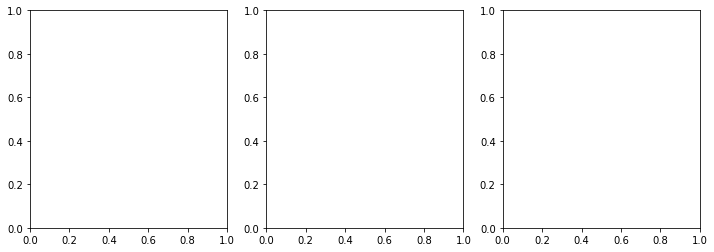

In [13]:
# Set up the figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Generate the images and configure each subplot
for i, year in enumerate([2012, 2017, 2022]):

    r_np = r_annual_121722.read(i+1)
    r_np = np.log(r_np+1)
    
    ax = axs[i]

    # Display the image
    ax.imshow(r_np, cmap='hot')
    ax.axis("off")
    ax.set_title("NTL: {}".format(year))

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

## Compute trends on nighttime lights over time <a name="trends">

We can use the `bm_extract` function to observe changes in nighttime lights over time. The `bm_extract` function leverages the [rasterstats](https://pythonhosted.org/rasterstats/) package to aggregate nighttime lights data to polygons. Below we show trends in annual nighttime lights data across Ghana's first administrative divisions.

In [8]:
ntl_df = bm_extract(roi_sf = roi_sf,
                    product_id = "VNP46A4",
                    date = list(range(2012, 2023)),
                    bearer = bearer,
                    quiet = True)

A1
Skipping 2013 due to error. Likely data is not available.

Skipping 2014 due to error. Likely data is not available.

Skipping 2015 due to error. Likely data is not available.

Skipping 2016 due to error. Likely data is not available.

Skipping 2017 due to error. Likely data is not available.

Skipping 2018 due to error. Likely data is not available.

Skipping 2019 due to error. Likely data is not available.

Skipping 2020 due to error. Likely data is not available.

Skipping 2021 due to error. Likely data is not available.

Skipping 2022 due to error. Likely data is not available.

A2
A3
A4
A5


In [6]:
ntl_df = bm_extract(roi_sf = roi_sf,
                    product_id = "VNP46A4",
                    date = list(range(2014, 2016)),
                    bearer = bearer,
                    quiet = False)

A1
B1
/var/folders/m1/8h14xfm56hd6qfgz6btm1rd80000gn/T/bm_raster_temp_1691170574005
True
C1a
C1b
C1c
C1d
C1e
C1f
C1g
C1h
C1
Downloading: VNP46A4.A2014001.h17v07.001.2021117183820.h5
Downloading: VNP46A4.A2014001.h17v08.001.2021119114632.h5
Downloading: VNP46A4.A2014001.h18v07.001.2021117184457.h5
Downloading: VNP46A4.A2014001.h18v08.001.2021117184219.h5
C2
C3
B2
B3
B4
B5
B6
B7
B8
B1
/var/folders/m1/8h14xfm56hd6qfgz6btm1rd80000gn/T/bm_raster_temp_1691170574005
True
C1a
C1b
C1c
C1d
C1e
C1f
C1g
C1h
C1
Downloading: VNP46A4.A2015001.h17v07.001.2021119013355.h5
Downloading: VNP46A4.A2015001.h17v08.001.2021119020717.h5
Downloading: VNP46A4.A2015001.h18v07.001.2021119011422.h5
Downloading: VNP46A4.A2015001.h18v08.001.2021119021051.h5
C2
C3
B2
B3
B4
B5
B6
B7
B8
A2
A3
A4
A5


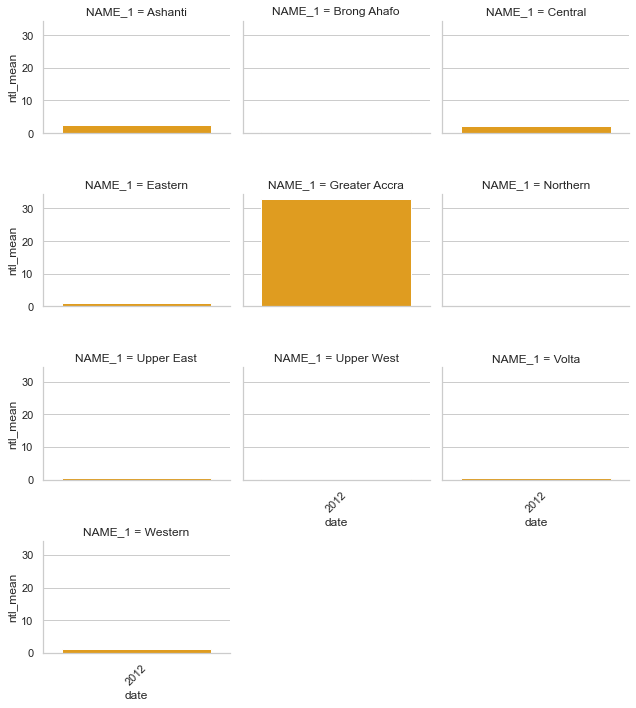

In [14]:
sns.set(style="whitegrid")
g = sns.catplot(data=ntl_df, kind="bar", x="date", y="ntl_mean", col="NAME_1", height=2.5, col_wrap = 3, aspect=1.2, color = "orange")

# Set the x-axis rotation for better visibility
g.set_xticklabels(rotation=45)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Export data to files <a name="to_file">

The above examples load raster data into memory. However, some workflows may benefit from first downloading raster data, then further processing it. The `bm_raster` and `bm_extract` functions facilitate these workflows.

#### Download annual data to files

By setting `output_location_type = "file"`, the functions will export data; `bm_raster` will export `.tif` files, and `bm_extract` will export `.csv` files. 

The functions will export one file per time period; for example, for annual data, an individual `.tif` or `.csv` file will be exported for each year. By default, the function will check if the file has already been downloaded and will skip already downloaded files. 

In [ ]:
# Define root directory
if os.path.exists("/Users/robmarty/Desktop"):
    root_dir = "/Users/robmarty/Desktop"
else:
    root_dir = os.getcwd()
    
# Directory for BlackMarble files
bm_files_path = os.path.join(root_dir, "bm_files")

# Directory to put individual daily files
annual_raster_path = os.path.join(root_dir, "bm_files", "annual_raster")
annual_csv_path    = os.path.join(root_dir, "bm_files", "annual_csv")

# Make directories
os.makedirs(bm_files_path, exist_ok=True)
os.makedirs(annual_raster_path, exist_ok=True)
os.makedirs(annual_csv_path, exist_ok=True)

In [ ]:
## Download annual raster data
## A .tif file for each year is exported to the "annual_raster_path" directory

bm_raster(roi_sf = roi_sf,
          product_id = "VNP46A4",
          date = list(range(2012, 2023)),
          bearer = bearer,
          quiet = True,
          output_location_type = "file",
          file_dir = annual_raster_path)

In [ ]:
## Download annual csv data, with average NTL data aggregated to first ADM level
## A .csv file for each year is exported to the "annual_csv_path" directory

bm_extract(roi_sf = roi_sf,
           product_id = "VNP46A4",
           date = list(range(2012, 2023)),
           bearer = bearer,
           quiet = True,
           output_location_type = "file",
           file_dir = annual_csv_path)

#### Workflow to update data

Some users may want to monitor near-real-time changes in nighttime lights. For example, daily Black Marble nighttime lights data is updated regularly, where data is available roughly on a week delay; some use cases may require examining trends in daily nighttime lights data as new data becomes available. Below shows example code that could be regularly run to produce an updated daily dataset of nighttime lights.

The below code produces a dataframe of nighttime lights for each date, where average nighttime lights for Ghana's 1st administrative division is produced. The code will check whether data has already been downloaded/extracted for a specific date, and only download/extract new data.

In [ ]:
# Make root directory
if os.path.exists("/Users/robmarty/Desktop"):
    root_dir = "/Users/robmarty/Desktop"
else:
    root_dir = os.getcwd()

# Directory for BlackMarble files
bm_files_path = os.path.join(root_dir, "bm_files")

# Directory to put individual daily files
daily_path    = os.path.join(root_dir, "bm_files", "daily")

os.makedirs(bm_files_path, exist_ok=True)
os.makedirs(daily_path, exist_ok=True)

In [ ]:
date_list = pd.date_range(datetime.datetime.strptime("2023-06-01", "%Y-%m-%d"), 
                                          datetime.date.today(), 
                                          freq='D').strftime("%Y-%m-%d").tolist()

bm_extract(roi_sf = roi_sf,
           product_id = "VNP46A2",
           date = date_list,
           bearer = bearer,
           output_location_type = "file",
           file_dir = os.path.join(root_dir, "bm_files", "daily"),
           quiet = True)

In [ ]:
#### Create individual file of daily nighttime lights

# Make list of daily NTL .csv files
file_list = glob.glob(os.path.join(root_dir, "bm_files", "daily") + "/" + "*.csv")

# Read individual .csv, make list of dataframes
df_list = [pd.read_csv(file) for file in file_list]

# Append dataframes
ntl_df = pd.concat(df_list, ignore_index=True)

# Export appended dataframes
ntl_df.to_csv(os.path.join(root_dir, "bm_files", "ntl_daily.csv"), index=False)

In [ ]:
ntl_df.head()